_version log: Improving Ettore's 2d interferogram function considering the number of data points_

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib import patches
from PIL import Image
import pandas as pd
import os, re, sys
from scipy import interpolate as sciinter, signal as scisig, optimize as sciopt, ndimage as sciimage #scipy has a lot of submodules
from astropy.io import fits
plt.rcParams.update({'font.size':14})
np.set_printoptions(threshold=sys.maxsize)

C = 299_792_458 #m/s
source = "ir" # "blue" "green" "red" "FBH800" "FBH1600" "ir" "big"
run = "6"
camera = "manta" #"manta" "xeva" "purple" "pyro"
file_type = ".tif" # the manta uses .tif, the xeva uses .csv, the purple camera can export .tif or .fts
dead_pixels = 0.1 # % of most anomalous pixels to replace with its nearest neighbour
anti_chirping = False #True for applying Elin's anti-chirping code.
zero_padding = 4 #factor to extrapolate the interferogram by. 1 means no extrapolation. 2 means that the interferogram will double in length. This should interpolate the spectrum rather than improving resolution.
apodization_function = "blackmann-harris" # None "box" "crop" "triangular" "happ-genzel" "blackmann-harris". None and "box" are identical unless you add zero-padding.
angle_calculation_method = "manual" # "manual" for a known angle, "wavelength" for calibration with a known wavelength or "delay" for calulation using a temporal change on the delay line.
angle_between_beams = 15.2/60 #degrees. Used if angle_calculation_method == "manual"
delay_line_delta = 2 #um. Distance traveled by delay line between each reading. Used if angle_calculation_method == "delay"
calibration_wavelength = 1.6 #um. Used if angle_calculation_method == "wavelength"
ROI = np.array([[0,492],[0,656]]) #region of interest in pixels. rows, columns. [[0,240],[0,320]] [[0,512],[0,640]] [[0,492],[0,656]]

if camera == "manta":
    pixel_pitch = 9.9 #um
elif camera == "xeva":
    pixel_pitch = 20 #um
elif camera == "purple":
    pixel_pitch = 48.5 #um
elif camera == "pyro":
    pixel_pitch = 80 #um
else:
    raise ValueError(camera + " is not a valid camera.")

In [2]:
#################FUNCTIONS##################

def none2zero(x): #x should be an interger or None
    return int(x or bool(x)) #a simple if statement would work best but I think this is cooler.

def line(x,A,B):
    return A + B*x
     
def cubic(x,A,B,C,D):
     return A + B*x + C*x**2 + D*x**3

def cubic_residuals(x, y, A, B, C, D):
    return cubic(x, A, B, C, D) - y

def recip(x):
    return C*1e-6 / x #converts um to THz or vice versa. be careful with units #1e4 / x #converts um to cm^-1 or vice versa. be careful with units

def format_ticks(x, pos):
    return f"{x:.1f}"  # Format the tick label with two decimal places

def find_best_peak(interferograms, height=None, threshold=None, distance=None, width=None, wlen=None, rel_height=0.5, plateau_size=None):
    if interferograms.ndim == 1:
        peaks, peaks_properties = scisig.find_peaks(interferograms, height=height, threshold=threshold, distance=distance, prominence=0, width=width, wlen=wlen, rel_height=rel_height, plateau_size=plateau_size)
        best_peak_index = np.argmax(peaks_properties["prominences"])
        peak = peaks[best_peak_index]
        peak_properties = {key: value[best_peak_index] for key, value in peaks_properties.items()}
    
    elif interferograms.ndim == 2:
        interferograms = interferograms.transpose() #Use the right set of axes.
        peaks, peaks_properties = scisig.find_peaks(interferograms[0], height=height, threshold=threshold, distance=distance, prominence=0, width=width, wlen=wlen, rel_height=rel_height, plateau_size=plateau_size)
        best_peak_index = np.argmax(peaks_properties["prominences"])
        peak = [peaks[best_peak_index]]
        peak_properties = {key: [value[best_peak_index]] for key, value in peaks_properties.items()}

        for interferogram in interferograms[1:]:
            peaks, peaks_properties = scisig.find_peaks(interferogram, height=height, threshold=threshold, distance=distance, prominence=0, width=width, wlen=wlen, rel_height=rel_height, plateau_size=plateau_size)
            best_peak_index = np.argmax(peaks_properties["prominences"])
            peak = np.concatenate([peak, [peaks[best_peak_index]]])
            peak_properties = {key: peak_properties[key] +[value[best_peak_index]] for key, value in peaks_properties.items()}

    return peak, peak_properties


def zero_pad(interferogram, zero_padding):
    original_length = len(interferogram)
    interferogram = np.concatenate([[interferogram[0]] *int((zero_padding-1) *original_length //2), interferogram])
    interferogram = np.concatenate([interferogram, [interferogram[-1]] *int((zero_padding-1) *original_length //2)])
    return interferogram

def apodization(interferogram, max_index = None, function = None, L = None):
    interferogram -= np.mean(interferogram) #apodization will fail if the background is significant (Ideally, the background is 0 anyway thanks to background subtraction.)

    # Setting defult values of L and max_index
    if L != None and max_index != None:
        max_index += (zero_padding-1) *L //2 # because the interferogram has been extended, the max_index has changed.
    elif L != None and max_index == None:
        max_index = L//2 + (zero_padding-1) *L //2
    elif L == None and max_index != None:
        L = len(interferogram)
    else: #L == None and max_index == None:
        L = len(interferogram)
        max_index = L//2

    index = np.arange(0, len(interferogram)) # We need indexes if we want to apply apodization

    if function == None:
        return interferogram # leave unchanged
    if function == "box":
        box_function = [1 if i >= (zero_padding-1) *L //2 and i < (zero_padding+1) *L //2 else 0 for i in index] # apply boundries. interferogram is invalid in zero-padded regions.
        box_function = np.array(box_function)
        interferogram = interferogram * box_function
        return interferogram
    if function == "crop":
        is_positive, is_negative = interferogram>=0, interferogram<0
        becomes_negative = np.logical_and(is_negative, np.roll(is_positive, 1))
        becomes_postive = np.logical_and(np.roll(is_negative, 1), is_positive)
        change_sign = np.logical_or(becomes_negative, becomes_postive)
        change_sign_indexes = np.arange(0,len(interferogram))[change_sign]
        start_index = change_sign_indexes[0]
        end_index = change_sign_indexes[-1]
        crop_function = [1 if i >= start_index and i < end_index else 0 for i in index] # apply boundries. interferogram is invalid beyond where it crosses zero.
        crop_function = np.array(crop_function)
        interferogram = interferogram * crop_function
        return interferogram
    if function == "triangular":
        triangular_function = 1 - np.abs(2/L *(index-max_index)) #definition of function
        triangular_function = [y if y >= 0 else 0 for y in triangular_function] #apply boundries. Negative values are invalid.
        triangular_function = np.array(triangular_function)
        interferogram = interferogram * triangular_function
        return interferogram
    if function == "happ-genzel":
        happ_genzel_function = 0.54 +0.46*np.cos(np.pi/L *(index-max_index)) #definition of function
        happ_genzel_function = [happ_genzel_function[i] if (i-max_index)/L >= -1 and (i-max_index)/L <= 1 else 0.08 for i in index] #apply boundries. Only the first period of the cosine is valid.
        happ_genzel_function = np.array(happ_genzel_function)
        return interferogram * happ_genzel_function
    if function == "blackmann-harris":
        blackmann_harris_function = 0.42323 +0.49755*np.cos(np.pi/L *(index-max_index)) +0.07922*np.cos(2*np.pi/L *(index-max_index)) #definition of function. This is the 3-term blackmann-harris.
        blackmann_harris_function = [blackmann_harris_function[i] if (i-max_index)/L >= -1 and (i-max_index)/L <= 1 else 0.0049 for i in index] #apply boundries. Only the first period of the cosine is valid.
        blackmann_harris_function = np.array(blackmann_harris_function)
        return interferogram * blackmann_harris_function
    
    raise ValueError(function + " is not a valid apodization function") #The code shouldn't reach this line


#Elin's anti-chirping function
def regularspacing(calibration, interferogram): #calibration intensities, interferogram intensities
    calibrationsmooth = sciimage.median_filter(calibration, 2) #reduces noise and dead pixels
    calibration_index = np.arange(*high_contrast_region) #create indexes for calibration.
    constructive_locs, _ = scisig.find_peaks(calibrationsmooth, width= 4) #locations of the contractive interferance.
    destructive_locs, _ = scisig.find_peaks(-calibrationsmooth, width= 4) #locations of the destructive interferance.
    fringe_locs = np.concatenate([constructive_locs, destructive_locs])
    fringe_locs = np.sort(fringe_locs)
    fringe_locs += high_contrast_region[0] #len(calibration) != len(interferogram) so we need to compensate for the change in index.

    liniar_locs = np.linspace(fringe_locs[0], fringe_locs[-1], len(fringe_locs)) #liniarly spaced version of the fringe locations
    
    coeffs, pcov = sciopt.curve_fit(cubic, liniar_locs, fringe_locs, bounds= ([-100,0,-1,0],[100,2,1,1]))

    liniar_index = sciopt.root(cubic_residuals, calibration_index, args=(calibration_index, *coeffs)).x #liniarise the indexes. Numerically solves the cubic equation.
    unchirped_intensity = np.interp(calibration_index, liniar_index, calibration) #map the indexes to the interferogram using liniar interpolation where nessisary.

    interferogram_index = np.arange(0, len(interferogram))
    extra_liniar_index = sciopt.root(cubic_residuals, interferogram_index, args=(interferogram_index, *coeffs)).x #liniarise the indexes
    extra_unchirped_intensity = np.interp(interferogram_index, extra_liniar_index, interferogram) #map the indexes to the interferogram using liniar interpolation where nessisary.

    plt.figure(figsize= (12,6))

    plt.subplot(1,2,1)
    plt.plot(fringe_locs, liniar_locs, marker= "x", linestyle = "None", label= "sampled points")
    plt.plot(interferogram_index, extra_liniar_index, label = str(coeffs))
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(interferogram)
    plt.plot(extra_unchirped_intensity)
    plt.vlines(high_contrast_region, np.min(interferogram), np.max(interferogram), color = "k")
    plt.show()

    return unchirped_intensity, extra_unchirped_intensity # unchirped intensities, extrapolated unchirped intensities

def find_fringes_files(colour, number):
    file_names = os.listdir("data\\")
    new_file_names=[]
    new_file_numbers=[]
    for file_name in file_names:
        check = re.findall('^'+colour+'_fringes'+number+'_*[0-9]*'+file_type , file_name)

        if len(check) != 0:
            new_file_names = new_file_names + [file_name]
            try:
                file_number = re.findall('_[0-9]+' , file_name)[0] #readings done with the delay line should look like this.
            except IndexError:
                file_number = "_0" #readings done without the delay line don't have a '_number' appendix.
            new_file_numbers = new_file_numbers + [int(file_number[1:])] #string indexing! Removes the '_' and saves the file number
    df = pd.DataFrame(np.transpose([new_file_names, new_file_numbers]), columns= ["file names", "file numbers"])
    df["file numbers"] = [int(number) for number in df["file numbers"]] #pandas forgot that numbers are intergers
    df = df.sort_values("file numbers", ignore_index= True) #I still don't know how to sort values using a key with numpy
    return df["file names"], df["file numbers"]

def combine_fringes_arrays(file_names):
    if file_type == ".tif" or file_type == ".tiff":
        im = Image.open('data\\'+file_names[0]) #for the first interferogram
        if im.mode == 'RGB': #The purple camera has colour channels dispite it being monochromatic.
            im = im.split()[0]
        angles = np.array(im, dtype= np.float32)
        for file_name in file_names[1:]: #for every other interferogram
            im = Image.open('data\\'+file_name)
            if im.mode == 'RGB':
                im = im.split()[0]
            Array = np.array(im, dtype= np.float32)
            angles = np.dstack([angles,Array])

    if file_type == ".csv":
        angles = np.loadtxt('data\\'+file_names[0], dtype= np.float32, delimiter=";")
        for file_name in file_names[1:]: #for every other interferogram
            Array = np.loadtxt('data\\'+file_name, dtype= np.float32, delimiter=";")
            angles = np.dstack([angles,Array])

    if file_type == ".fts":
        hdulist = fits.open('data\\'+file_names[0],  ignore_missing_end=True)
        angles = np.array(hdulist[0].data)
        hdulist.close()
        for file_name in file_names[1:]: #for every other interferogram
            hdulist = fits.open('data\\'+file_name,  ignore_missing_end=True)
            Array = np.array(hdulist[0].data)
            hdulist.close()
            angles = np.dstack([angles,Array])

    return angles  

def import_standard_photo(colour, number): #It would be nice to combine import_standard_photo and combine_fringes_arrays into a single function. They do basically the same thing.
    if file_type == ".tif" or file_type == ".tiff":
        im = Image.open('data\\'+colour+'_BA'+number+file_type)
        if im.mode == 'RGB': #The purple camera has colour channels dispite it being monochromatic.
            im = im.split()[0]
        beamA = np.array(im, dtype= np.float32)
        im.close()
        im = Image.open('data\\'+colour+'_BB'+number+file_type)
        if im.mode == 'RGB':
            im = im.split()[0]
        beamB = np.array(im, dtype= np.float32)
        im.close()
        im = Image.open('data\\'+colour+'_bg'+number+file_type)
        if im.mode == 'RGB':
            im = im.split()[0]
        background = np.array(im, dtype= np.float32)
        im.close()

    if file_type == ".csv":
        beamA = np.loadtxt('data\\'+colour+'_BA'+number+file_type, delimiter=";")
        beamB = np.loadtxt('data\\'+colour+'_BB'+number+file_type, delimiter=";")
        background = np.loadtxt('data\\'+colour+'_bg'+number+file_type, delimiter=";")

    if file_type == ".fts":
        hdulist = fits.open('data\\'+colour+'_BA'+number+file_type,  ignore_missing_end=True)
        beamA = np.array(hdulist[0].data)
        hdulist.close()
        hdulist = fits.open('data\\'+colour+'_BB'+number+file_type,  ignore_missing_end=True)
        beamB = np.array(hdulist[0].data)
        hdulist.close()
        hdulist = fits.open('data\\'+colour+'_bg'+number+file_type,  ignore_missing_end=True)
        background = np.array(hdulist[0].data)
        hdulist.close()

    file_names, _ = find_fringes_files(colour= colour, number= number)
    fringes = combine_fringes_arrays(file_names= file_names)

    return fringes, beamA, beamB, background

def dead_pixel_filter(interferogram):
    # Remove the most anomalous 1% of pixels and replace with nearest nearbour.
    upper_percentile = 100 - dead_pixels/2
    lower_percentile = dead_pixels/2
    notdead = np.logical_and(interferogram <= np.percentile(interferogram,upper_percentile), interferogram >= np.percentile(interferogram,lower_percentile) )
    coords = np.mgrid[0:interferogram.shape[0], 0:interferogram.shape[1]]
    coords = np.moveaxis(coords, 0, -1) #refromat the array such that we have pairs of coordinates. ie. [[0,0],[0,1],[0,2]] ect.
    nearest = sciinter.NearestNDInterpolator(coords[notdead], interferogram[notdead])
    interferogram = nearest(coords[:,:,0],coords[:,:,1])

    return interferogram

def process_fringes(fringes, beamA, beamB, background):
    if fringes.ndim == 3:
        nofringes = np.dstack([beamA +beamB -background] *fringes.shape[2]) #This will throw an error if fringes is 2d
        beamPost = fringes - nofringes #take away background.
        if bool(dead_pixels):
            for n in np.arange(0,beamPost.shape[2]):
                beamPost[:,:,n] = dead_pixel_filter(beamPost[:,:,n]) #I can't figure out how to vectorise this bit :/

    elif fringes.ndim == 2:
        nofringes = beamA +beamB -background #ignore the error
        beamPost = fringes - nofringes #take away background.
        if bool(dead_pixels):
            beamPost = dead_pixel_filter(beamPost)

    return beamPost[ROI[0][0]:ROI[0][1], ROI[1][0]:ROI[1][1]], nofringes[ROI[0][0]:ROI[0][1], ROI[1][0]:ROI[1][1]]

def apply_cross_corrlations(angle_averages, reference_signal, reference_maximum = 0):
        
    if angle_averages.ndim == 1:
        cross_corrs = scisig.correlate(angle_averages, reference_signal, mode='full') #use average_signal as a reference to find the displacements.
        lags = scisig.correlation_lags(len(angle_averages), len(reference_signal), mode='full')
        displacements = lags[np.argmax(cross_corrs)] +reference_maximum +int((zero_padding-1) *len(angle_averages) //2)

    elif angle_averages.ndim == 2:
        cross_corrs = scisig.correlate(angle_averages[:,0], reference_signal, mode='full') #use average_signal as a reference to find the displacements.
        lags = scisig.correlation_lags(len(angle_averages[:,0]), len(reference_signal), mode='full')
        displacements = lags[np.argmax(cross_corrs)] +reference_maximum +int((zero_padding-1) *len(angle_averages) //2)

        for n in np.arange(1,angle_averages.shape[1]): #for every other interferogram
            cross_corr = scisig.correlate(angle_averages[:,n], reference_signal, mode='full') #use average_signal as a reference to find the displacements.
            lags = scisig.correlation_lags(len(angle_averages[:,n]), len(reference_signal), mode='full')
            displacement = lags[np.argmax(cross_corr)] +reference_maximum +int((zero_padding-1) *len(angle_averages) //2)
            displacements = np.hstack([displacements,displacement])
            cross_corrs = np.vstack([cross_corrs,cross_corr])

    return displacements, cross_corrs

def Coeffients2Amplitudes(FT, freqs):
    samples = len(FT)
    num_of_freqs = len(FT)//2 +1
    amplitude = np.zeros(num_of_freqs)
    amplitude[0] = np.abs(FT[0])
    if (samples//2 == samples/2): #if even
        amplitude[-1] = np.abs(FT[num_of_freqs-1])
        amplitude[1:-1] = (np.abs( FT[1:num_of_freqs-1] ) +
                            np.abs( FT[:num_of_freqs-1:-1] ))

        freqs = freqs[:num_of_freqs]
        freqs[-1] = -freqs[-1] #The niquist freqency is considered to be negative by np.fft.fftfreq(). This should make it positive.
        wavelengths = 1/freqs
    else: #if odd
        amplitude[1:] = (np.abs( FT[1:num_of_freqs] ) +
                        np.abs( FT[:num_of_freqs-1:-1] ))
        
        freqs = freqs[:num_of_freqs]
        wavelengths = 1/freqs
    return amplitude, wavelengths, freqs

def import_normalised_csv(file_name, start_row):
    File = open('data\\'+file_name, 'rt')
    array = np.loadtxt(File, skiprows=start_row, delimiter = ",")
    File.close()
    array[:,1] = array[:,1] / np.max(array[:,1]) #normalise
    return array

In [3]:
fringes, beamA, beamB, background = import_standard_photo(source, run)

fringes_processed, nofringes = process_fringes(fringes, beamA, beamB, background)
fringes_averaged = np.mean(fringes_processed, axis = 0)

maximums,_ = find_best_peak(fringes_averaged) #find the center of the fringes
maximums_offsets = (fringes.shape[1]//2) - maximums #the center of the fringes might not be in the center of the image

reference_index = np.argmin(np.abs(maximums_offsets)) #find out which interferogram is centered on the image.
#This interferogram is special and it deserves its own variables.
reference_index = 0


if fringes.ndim == 3:
    reference, reference_processed, reference_averaged, reference_offset, reference_nofringes, reference_maximum = fringes[:,:,reference_index], fringes_processed[:,:,reference_index], fringes_averaged[:,reference_index], maximums_offsets[reference_index], nofringes[:,:,reference_index], maximums[reference_index]
elif fringes.ndim == 2: # only 1 fringes file found
    reference, reference_processed, reference_averaged, reference_offset, reference_nofringes = fringes, fringes_processed, fringes_averaged, maximums_offsets, nofringes


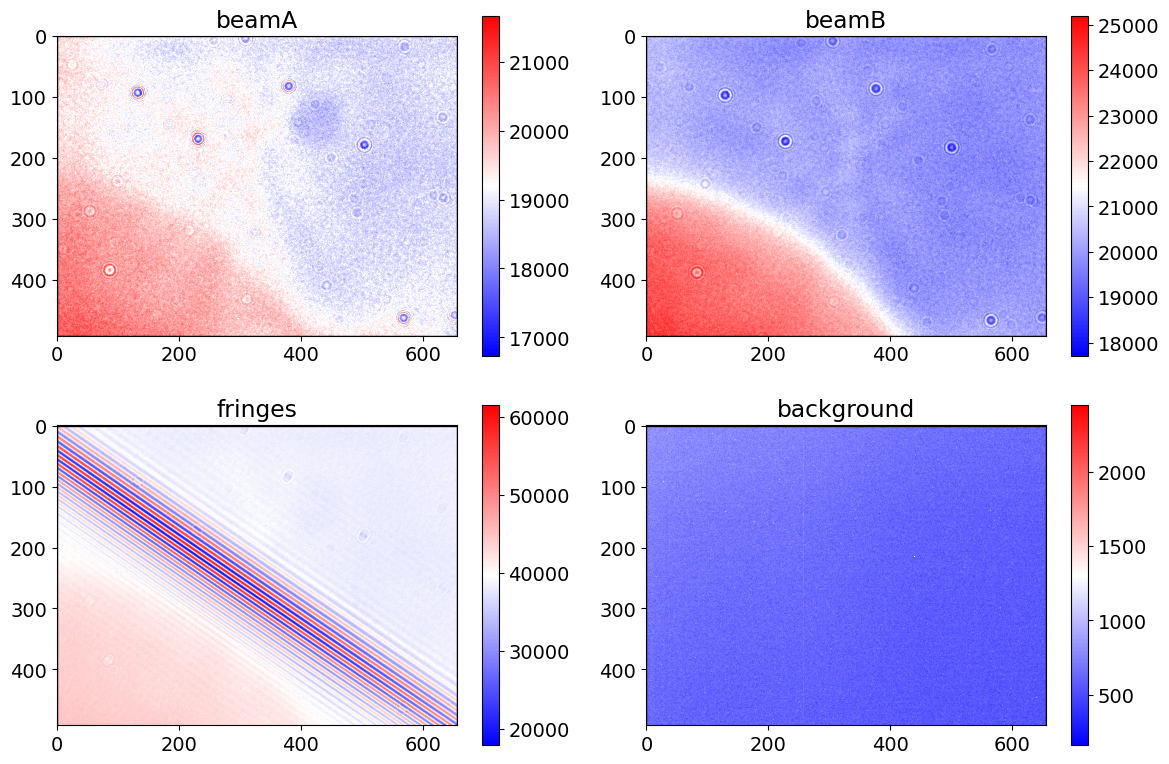

In [4]:
plt.figure(figsize= (12,8))

ax1= plt.subplot(2,2,1)
im=plt.imshow(beamA, cmap='bwr')
plt.colorbar(im)
rect1 = patches.Rectangle((ROI[1][0], ROI[0][0]), ROI[1][1]-ROI[1][0], ROI[0][1]-ROI[0][0], linewidth=1, edgecolor='k', facecolor='none')
ax1.add_patch(rect1)
plt.title("beamA")

ax2= plt.subplot(2,2,2)
im=plt.imshow(beamB, cmap='bwr')
plt.colorbar(im)
rect2 = patches.Rectangle((ROI[1][0], ROI[0][0]), ROI[1][1]-ROI[1][0], ROI[0][1]-ROI[0][0], linewidth=1, edgecolor='k', facecolor='none')
ax2.add_patch(rect2)
plt.title("beamB")

ax3= plt.subplot(2,2,3)
im=plt.imshow(reference, cmap='bwr')
plt.colorbar(im)
rect3 = patches.Rectangle((ROI[1][0], ROI[0][0]), ROI[1][1]-ROI[1][0], ROI[0][1]-ROI[0][0], linewidth=1, edgecolor='k', facecolor='none')
ax3.add_patch(rect3)
plt.title("fringes")

ax4= plt.subplot(2,2,4)
im=plt.imshow(background, cmap='bwr')
plt.colorbar(im)
rect4 = patches.Rectangle((ROI[1][0], ROI[0][0]), ROI[1][1]-ROI[1][0], ROI[0][1]-ROI[0][0], linewidth=1, edgecolor='k', facecolor='none')
ax4.add_patch(rect4)
plt.title("background")

plt.tight_layout()
plt.show()

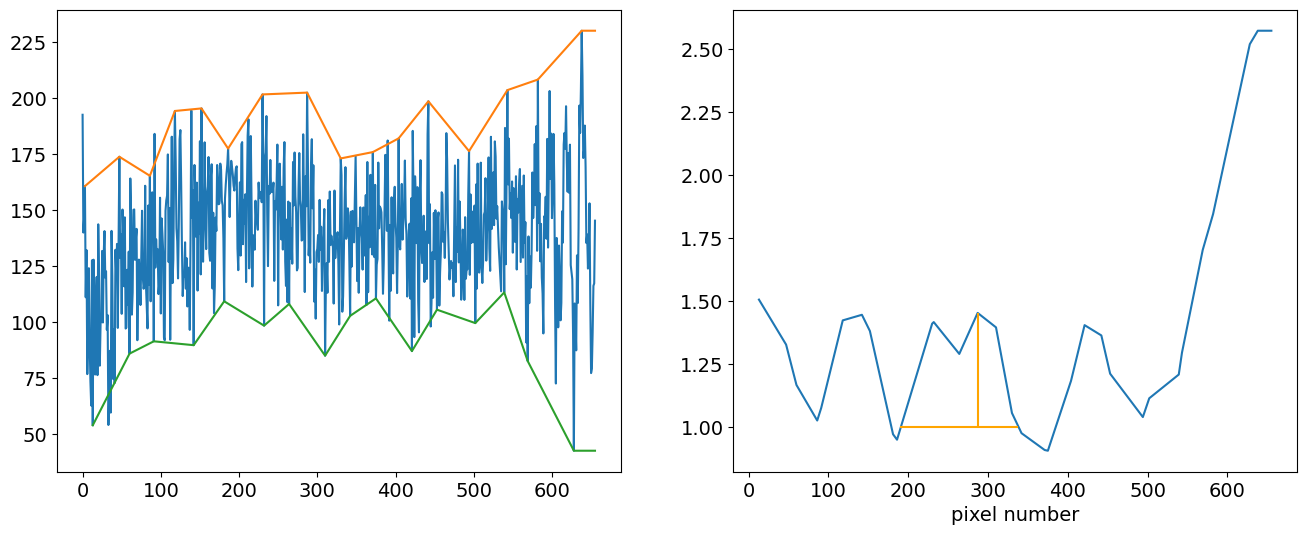

In [5]:
fringe_width_estimate = 30 #pixels. Small values may misidentify noise as fringes, large values may miss some fringes.

df = pd.DataFrame(reference_averaged, columns= ["interferogram"])
#df["rolling_average"] = df["interferogram"].rolling(5, center=True, min_periods= 0).mean() #Can be useful for reducing noise but also reduces contrast

peak_index, peak_properties = scisig.find_peaks(df["interferogram"], height= -np.Infinity, distance= fringe_width_estimate)
df.loc[peak_index, "max"] = peak_properties["peak_heights"]
df["max"].interpolate(inplace=True)
peak_index, peak_properties = scisig.find_peaks(-df["interferogram"], height= -np.Infinity, distance= fringe_width_estimate)
df.loc[peak_index, "min"] = -peak_properties["peak_heights"]
df["min"].interpolate(inplace=True)

df["range"] = df["max"] - df["min"]
noise = df["range"].min()

peak_index, peak_properties = find_best_peak(df["range"], height = 0, width = 0, rel_height= 0.9)
peak_left_index = peak_properties["left_ips"]
peak_right_index = peak_properties["right_ips"]
peak_height = peak_properties["peak_heights"]
peak_threshold = peak_properties["width_heights"]

high_contrast_region = [int(peak_left_index), int(peak_right_index)]

plt.figure(figsize= (16,6))

plt.subplot(1,2,1)
plt.plot(df["interferogram"])
plt.plot(df["max"])
plt.plot(df["min"])

plt.subplot(1,2,2)
plt.plot(df["range"] /peak_threshold)
plt.hlines(peak_threshold /peak_threshold, *high_contrast_region, color = "orange")
plt.vlines(peak_index, peak_threshold /peak_threshold, peak_height /peak_threshold, color= "orange")
plt.xlabel("pixel number")
plt.show()

reference_maximum = peak_index

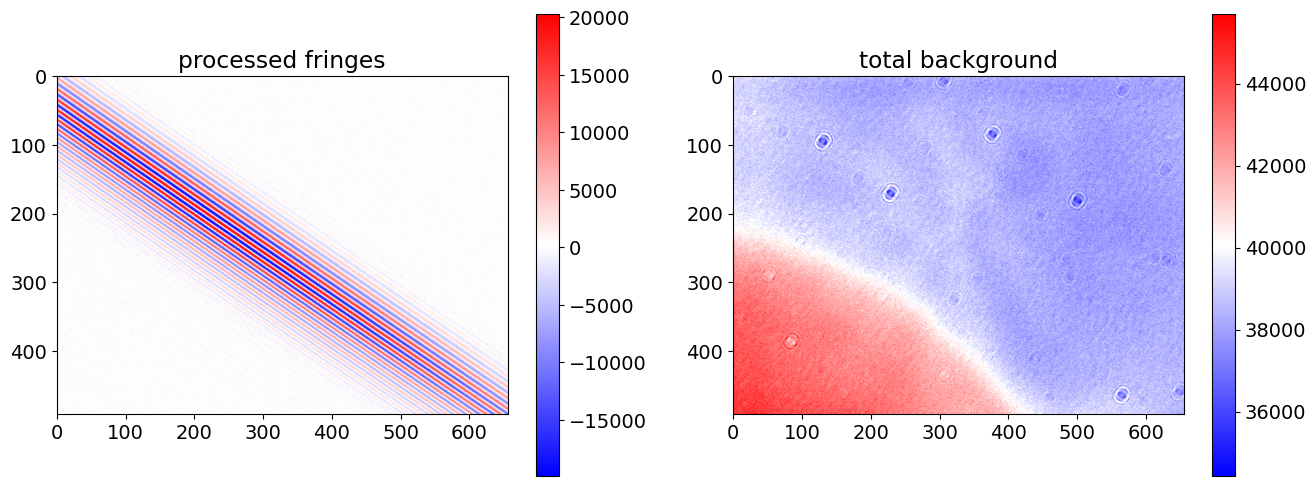

In [6]:
plt.figure(figsize = (16,6))

ax = plt.subplot(1,2,1)
im=plt.imshow(reference_processed, cmap='bwr')
plt.colorbar(im)
plt.title("processed fringes")

plt.subplot(1,2,2)
im=plt.imshow(reference_nofringes, cmap='bwr')
plt.colorbar(im)
plt.title("total background")

plt.show()

In [7]:
# Ettore's angular_slice function
def angular_slice(phi, FT2ds):

    angle_of_diagonal = np.tan(FT2ds.shape[0] / FT2ds.shape[1])
    n = phi // np.pi #We need the angle to be between -pi < phi < pi

    x_center = (FT2ds.shape[1]//2 +0.5) * (1/(FT2ds.shape[1] *pixel_pitch)) #um^-1
    y_center = (FT2ds.shape[0]//2 +0.5) * (1/(FT2ds.shape[0] *pixel_pitch)) #um^-1

    if np.pi -np.abs(angle_of_diagonal) +np.pi*n < phi and np.abs(angle_of_diagonal) +np.pi*n > phi:    #line segment reaches from 'floor to ceiling' - from the bottom of the image to the top.
        number_of_samples = FT2ds.shape[0]
        niquist = 1 /pixel_pitch /np.sin(phi)
    elif np.abs(angle_of_diagonal) +2*np.pi*n == phi:                                                               #line segment reaches from corner to corner.
        number_of_samples = np.max(FT2ds.shape)
        niquist = np.sum(np.array(2*[1/pixel_pitch])**2)**0.5
    else:                                                                                                           #line segment reaches from 'side to side' -from the left hand side of the image to the right.
        number_of_samples = FT2ds.shape[1]
        niquist = 1 /pixel_pitch /np.cos(phi)
    
    if number_of_samples//2 == number_of_samples/2:
        number_of_samples += 1 #must be odd otherwise it will not be centered on zero.

    line_x = np.fft.fftshift(np.fft.fftfreq(number_of_samples, 1/niquist)) *np.cos(phi) +x_center
    line_y = np.fft.fftshift(np.fft.fftfreq(number_of_samples, 1/niquist)) *np.sin(phi) +y_center
    line_coords = np.vstack((line_y,line_x)).T #create pairs of coordinates. [[x1,y1],[x2,y2],[x3,y3]]

    grid_x = np.linspace(+1/(2*pixel_pitch*FT2ds.shape[1]),
                        1/pixel_pitch -1/(2*pixel_pitch*FT2ds.shape[1]),
                        FT2ds.shape[1])
    grid_y = np.linspace(+1/(2*pixel_pitch*FT2ds.shape[0]),
                        1/pixel_pitch -1/(2*pixel_pitch*FT2ds.shape[0]),
                        FT2ds.shape[0])
    grid_coords = (grid_y, grid_x)

    if FT2ds.ndim == 2:
        interp = sciinter.RegularGridInterpolator(grid_coords, FT2ds, bounds_error= False, fill_value= 0)
        FT1ds = interp(line_coords)
        FT1ds = FT1ds[~np.isnan(FT1ds)] #delete nan values
        sums = np.nansum(np.abs(FT1ds)) #np.sum should also be ok because the nans have been removed

    elif FT2ds.ndim == 3:
        interp = sciinter.RegularGridInterpolator(grid_coords, FT2ds[0], bounds_error= False, fill_value= np.nan)
        FT1ds = interp(line_coords)
        FT1ds = FT1ds[~np.isnan(FT1ds)] #delete nan values
        sums = np.nansum(np.abs(FT1ds)) #np.sum should also be ok because the nans have been removed
        for FT2d in FT2ds[1:]:
            interp = sciinter.RegularGridInterpolator(grid_coords, FT2d, bounds_error= False, fill_value= np.nan)
            FT1d = interp(line_coords)
            sum = np.nansum(np.abs(FT1d)) #np.sum should also be ok because the nans have been removed
            FT1ds = np.hstack([FT1ds, FT1d])
            sums = np.hstack([sums, sum])

    return sums, FT1ds, np.fft.fftshift(np.fft.fftfreq(number_of_samples, 1/niquist)) #line intergral (counts), line slice (counts), slice frequencies (pixels^-1)

def angular_intergral(phi, FT2d, sign = 1): #function for scipy minimization
    sum ,_ ,_ = angular_slice(phi, FT2d)
    return sign *sum #I acually want the maximum so I set sign = -1

In [8]:
FT2d = np.fft.fftshift(np.fft.fft2(reference_processed, norm= "forward"))

minimisation_results = sciopt.minimize(angular_intergral, x0= -1, args= (FT2d, -1), bounds= [[-np.pi/2, np.pi/2]])
min_phi, min_intergral = minimisation_results.x, minimisation_results.fun
print("The fringes are tilted by {:.2f} radians".format(float(min_phi)))

########
angle_of_diagonal = np.tan(FT2d.shape[0] / FT2d.shape[1])
n = min_phi // np.pi #We need the angle to be between -pi < phi < pi

x_center = (FT2d.shape[1]//2 + 0.5) * (1/(FT2d.shape[1] *pixel_pitch)) #um^-1
y_center = (FT2d.shape[0]//2 + 0.5) * (1/(FT2d.shape[0] *pixel_pitch)) #um^-1

if np.pi -np.abs(angle_of_diagonal) +np.pi*n < min_phi and np.abs(angle_of_diagonal) +np.pi*n > min_phi:    #line segment reaches from 'floor to ceiling' - from the bottom of the image to the top.
    number_of_samples = FT2d.shape[0]
    niquist = 1 /pixel_pitch /np.sin(min_phi)
elif np.abs(angle_of_diagonal) +2*np.pi*n == min_phi:                                                               #line segment reaches from corner to corner.
    number_of_samples = np.max(FT2d.shape)
    niquist = np.sum(np.array(2*[1/pixel_pitch])**2)**0.5
else:                                                                                                           #line segment reaches from 'side to side' -from the left hand side of the image to the right.
    number_of_samples = FT2d.shape[1]
    niquist = 1 /pixel_pitch /np.cos(min_phi)
    
if number_of_samples//2 == number_of_samples/2:
    number_of_samples += 1 #must be odd otherwise it will not be centered on zero.

line_x = np.fft.fftshift(np.fft.fftfreq(number_of_samples, 1/niquist)) *np.cos(min_phi) +x_center
line_y = np.fft.fftshift(np.fft.fftfreq(number_of_samples, 1/niquist)) *np.sin(min_phi) +y_center
######

The fringes are tilted by -0.97 radians


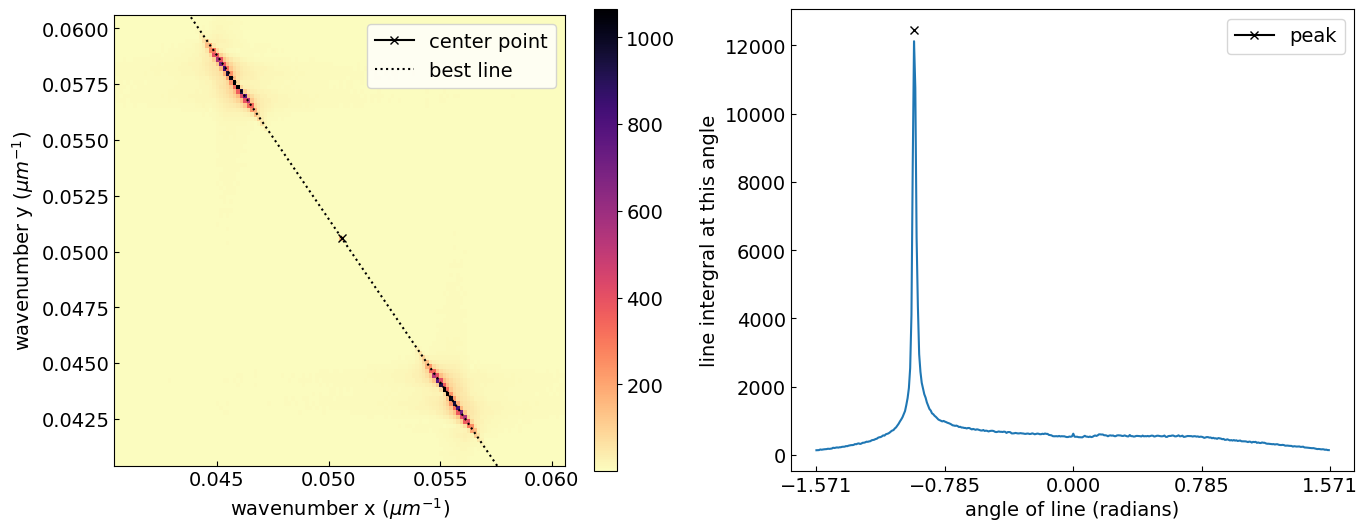

In [9]:
plt.figure(figsize= (16,6))

ax = plt.subplot(1,2,1)
ax.tick_params(direction = "in")
im=plt.imshow(np.abs(FT2d), interpolation= "None", origin= "lower", extent= (0, 1/pixel_pitch, 0, 1/pixel_pitch), cmap= "magma_r")#, norm= "log",)
ax.plot(x_center, y_center, marker= "x", color= "k", label= "center point")
ax.plot(line_x, line_y, color= "k", label= "best line", linestyle= ":")
plt.colorbar(im)
plt.legend()

plt.xlim(0.4/pixel_pitch, 0.6/pixel_pitch)
plt.ylim(0.4/pixel_pitch, 0.6/pixel_pitch)
plt.xlabel("wavenumber x ($\mu{m}^{-1}$)")
plt.ylabel("wavenumber y ($\mu{m}^{-1}$)")

ax1 = plt.subplot(1,2,2)
ax1.tick_params(direction = "in")
phis = np.arange(-np.pi/2, np.pi/2, np.pi/400)

intergral = []
for phi in phis:
    intergral = [*intergral, angular_intergral(phi, FT2d)]

plt.plot(phis, np.array(intergral))
plt.plot(min_phi, -min_intergral, marker= "x", color= "k", label= "peak")
plt.xlabel("angle of line (radians)")
plt.ylabel("line intergral at this angle")
plt.legend()
plt.xticks(np.pi*np.array([-0.5,-0.25,0,0.25,0.5]))

plt.show()

In [24]:
min_phi

array([-0.9717193])

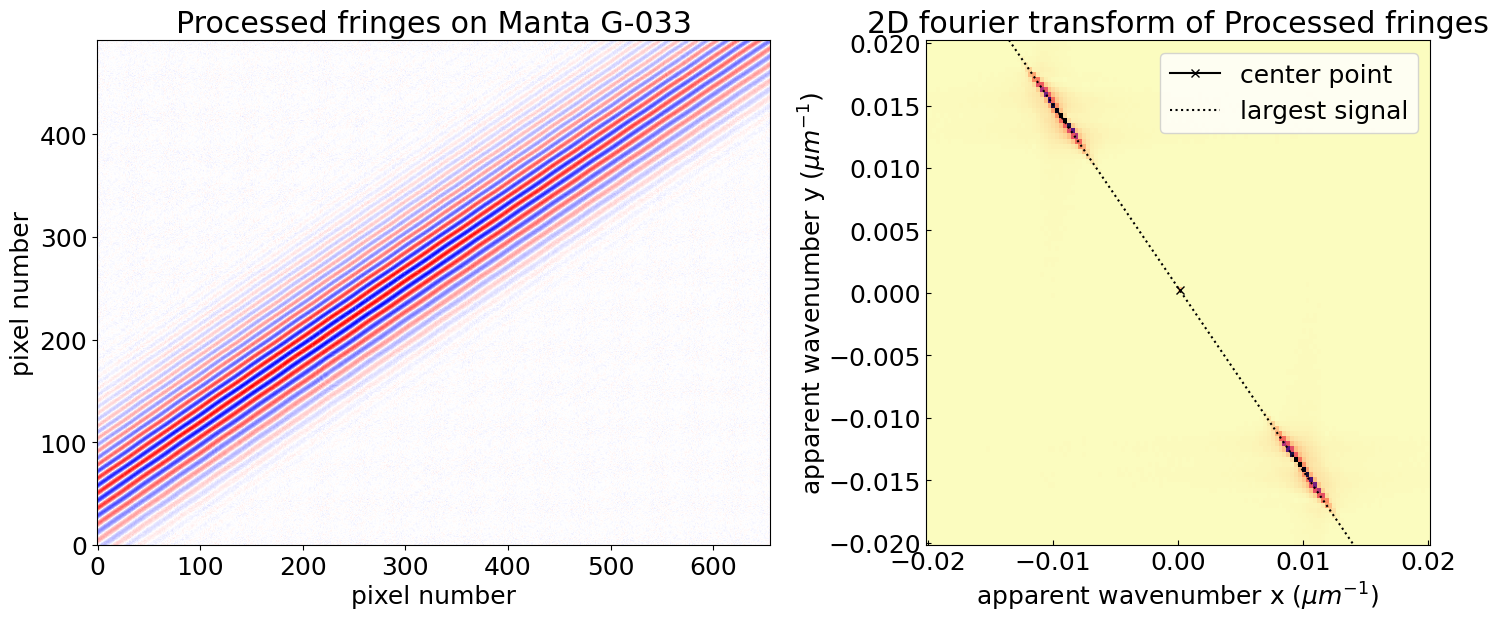

In [10]:
x_center = 1/(FT2d.shape[1] *pixel_pitch) #um^-1
y_center = 1/(FT2d.shape[0] *pixel_pitch) #um^-1
line_x = np.fft.fftshift(np.fft.fftfreq(number_of_samples, 1/niquist)) *np.cos(min_phi) +x_center
line_y = np.fft.fftshift(np.fft.fftfreq(number_of_samples, 1/niquist)) *np.sin(min_phi) +y_center

a = reference_processed.shape[1] /reference_processed.shape[0]
b = 1 # (1/pixel_pitch - -1/pixel_pitch) / (1/pixel_pitch - -1/pixel_pitch)


plt.rcParams.update({'font.size':18})
fig, axes = plt.subplots(1, 2, figsize= (15,10), gridspec_kw={'width_ratios': [a, b]})

axes[0] = plt.subplot(1,2,1)
im=plt.imshow(reference_processed, cmap='bwr', origin= "lower")
plt.title("Processed fringes on Manta G-033")
plt.xlabel("pixel number")
plt.ylabel("pixel number")


axes[1] = plt.subplot(1,2,2)
axes[1].tick_params(direction = "in")
im=plt.imshow(np.abs(FT2d), interpolation= "None", origin= "lower", extent= (-1/pixel_pitch, 1/pixel_pitch, -1/pixel_pitch, 1/pixel_pitch), cmap= "magma_r")#, norm= "log",)
axes[1].plot(x_center, y_center, marker= "x", color= "k", label= "center point")
axes[1].plot(line_x, line_y, color= "k", label= "largest signal", linestyle= ":")
plt.legend()

plt.xlim(-0.2/pixel_pitch, 0.2/pixel_pitch)
plt.ylim(-0.2/pixel_pitch, 0.2/pixel_pitch)

plt.title("2D fourier transform of Processed fringes")
plt.xlabel("apparent wavenumber x ($\mu{m}^{-1}$)")
plt.ylabel("apparent wavenumber y ($\mu{m}^{-1}$)", labelpad= -1)

plt.tight_layout()
plt.show()

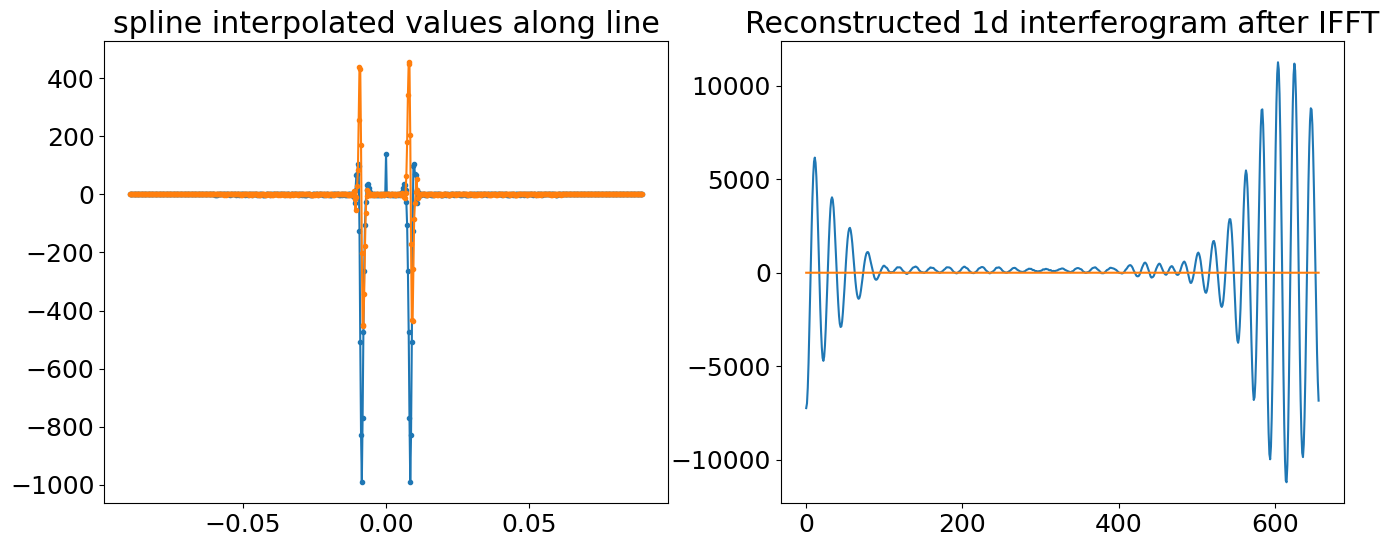

In [11]:
_, FT1d, freqs = angular_slice(min_phi, FT2d)
reference_sliced = np.fft.ifft(np.fft.ifftshift(FT1d), norm= "forward")
#reference_sliced = np.fft.fftshift(reference_sliced)

plt.figure(figsize= (16,6))

ax = plt.subplot(1,2,1)
ax.plot(freqs, np.real(FT1d), marker = ".")
ax.plot(freqs, np.imag(FT1d), marker = ".")
plt.title("spline interpolated values along line")

ax1 = plt.subplot(1,2,2)
ax1.plot(np.real(reference_sliced))
ax1.plot(np.imag(reference_sliced))
plt.title("Reconstructed 1d interferogram after IFFT")

plt.show()

In [12]:
a = np.fft.ifftshift(FT1d)
b = np.real(a[1:] - a[:0:-1]) # because our interferogram is real, the real fft should be symetric
c = np.imag(a[1:] + a[:0:-1]) # because our interferogram is real, the imaginary fft should be anti-symetric
print("The largest error amongst the real values is {:.1e}".format(np.max(b)))
print("The largest error amongst the imaginary values is {:.1e}".format(np.max(c)))

The largest error amongst the real values is 3.5e-01
The largest error amongst the imaginary values is 4.2e-11


In [13]:
if anti_chirping == True:
    _, reference_unchirped = regularspacing(reference_sliced[high_contrast_region[0]:high_contrast_region[1]], reference_sliced)
else:
    reference_unchirped = reference_sliced

C:\Users\syf83691\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\matplotlib\cbook\__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


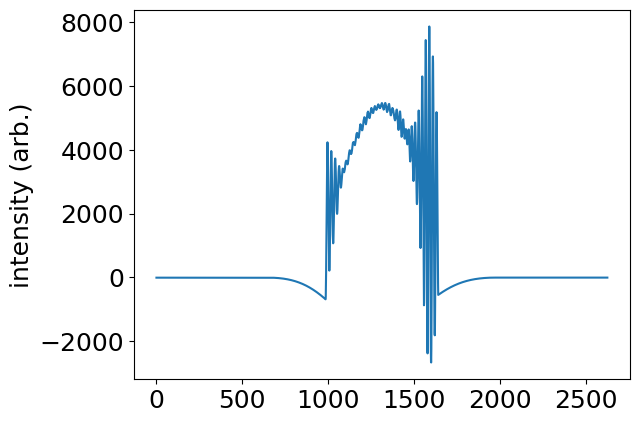

In [14]:
reference_zeropadded = zero_pad(reference_unchirped, zero_padding)
reference_apodized = apodization(reference_zeropadded, function= apodization_function, L= len(reference_unchirped))

plt.plot(reference_apodized)

plt.ylabel("intensity (arb.)")
plt.show()

In [15]:
#dummy = np.ones(reference_apodized.shape)
#dummy = apodization(dummy, function = apodization_function, L= len(reference_unchirped))
#plt.plot(dummy)
#plt.ylabel("intensity (arb.)")
#plt.show()

In [16]:
delay_line_bounds = [2,-7] #As the fringes move outside of the high_contrast_region, the peak position becomes inaccurate. Use None to include the last interferogram

if angle_calculation_method == "delay":

    delay_line_travel = np.arange(fringes_averaged.shape[1]) *delay_line_delta
    time_delay = delay_line_travel *2 /C
    time_delay *= 1e9 #convert from us to fs

    #we found the maximums earlier
    minimums,_ = find_best_peak(-fringes_averaged)
    cross_corr_lags, cross_corr = apply_cross_corrlations(fringes_averaged, reference_apodized, reference_maximum= reference_maximum) #will fail if background is still present

    all_peak_estimates = maximums[delay_line_bounds[0]:delay_line_bounds[1]] #np.concatenate((maximums[delay_line_bounds[0]:delay_line_bounds[1]], minimums[delay_line_bounds[0]:delay_line_bounds[1]], cross_corr_lags[delay_line_bounds[0]:delay_line_bounds[1]]))
    time_delays = list(time_delay[delay_line_bounds[0]:delay_line_bounds[1]])*1 #3

    popt, pcov = sciopt.curve_fit(line, all_peak_estimates, time_delays)
    k = popt[0]
    m = popt[1]
    err_k = np.sqrt(pcov[0][0]) /k #make into percentage error
    err_m = np.sqrt(pcov[1][1]) /m

    plt.figure(figsize = (12,8))

    ax = plt.subplot(1,1,1)
    im=plt.imshow(np.transpose(fringes_averaged), 
                cmap='bwr', 
                aspect = "auto", 
                interpolation = "none", #"none" and "nearest" are the only physical ones
                origin = "lower", 
                extent=[0, fringes_averaged.shape[0], 0 -time_delay[1]/2, time_delay[-1] +time_delay[1]/2])
    plt.colorbar(im)
    plt.plot(maximums,
            time_delay,
            label = "maximums",
            marker = "x")
    plt.plot(minimums,
            time_delay,
            label = "minimums",
            marker = "x")
    plt.plot(cross_corr_lags,
            time_delay,
            label = "cross-correlation",
            marker = "x")
    # Datapoints between the black lines will be used to calculate the angle.
    plt.hlines([time_delay[delay_line_bounds[0]] -time_delay[1]/2, time_delay[none2zero(delay_line_bounds[1]) -1] +time_delay[1]/2], #y position(s)
               0, #x start
               fringes_averaged.shape[0], #x finish
               color = "k")
    plt.ylabel('delay due to delay line (fs)')
    plt.xlabel('position of peak (pixels)')
    plt.legend()

    plt.show()

In [17]:
if angle_calculation_method == "delay":
    print("gradient = {0:.2e} +/- {1:.1e} ".format(m, err_m*m) + "fs/pixel")

    m /= 1e9 *pixel_pitch #convert the gradient from fs/pixel to um/us (= m/s)
    theta = np.arcsin(C *np.abs(m) /2 ) 
    angle_between_beams = 2 *theta *180/np.pi #convert from radians to degrees
    err_angle = angle_between_beams *np.abs(err_m) #relies on the small angle appoximation.
    print("angle between beams = {0:.3f} +/- {1:.3f}° or {2:.1f} +/- {3:.1f} arcminutes".format(angle_between_beams, 2*err_angle, 60*angle_between_beams, 60*2*err_angle))

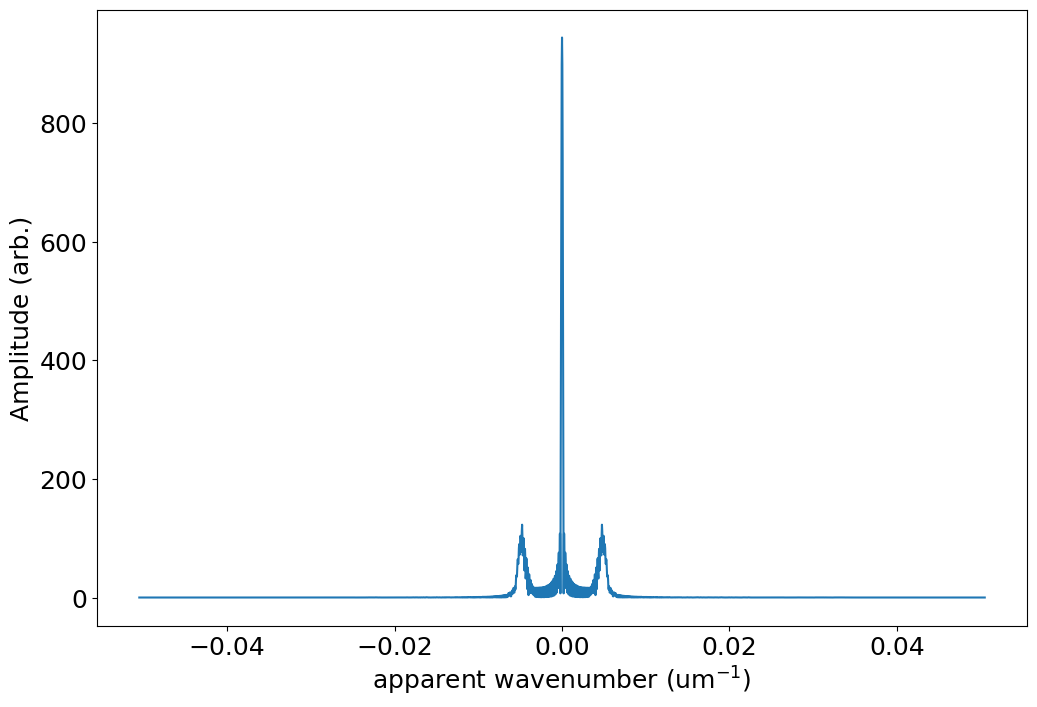

In [18]:
FT = np.fft.fft(reference_apodized, norm = "forward")

num_of_freqs = len(FT)//2 +1
samples = len(FT)
freqs = np.fft.fftfreq(len(FT), pixel_pitch)

plt.figure(figsize = (12,8))
plt.subplot(1, 1, 1)

plt.plot(np.fft.fftshift(freqs), #plt works best when the data set is in order
        np.fft.fftshift(abs(FT)))

plt.xlabel('apparent wavenumber (um$^{-1}$)')
plt.ylabel('Amplitude (arb.)')

plt.show()

C:\Users\syf83691\AppData\Local\Temp\ipykernel_21056\1039869562.py:297: RuntimeWarning: divide by zero encountered in divide
  wavelengths = 1/freqs


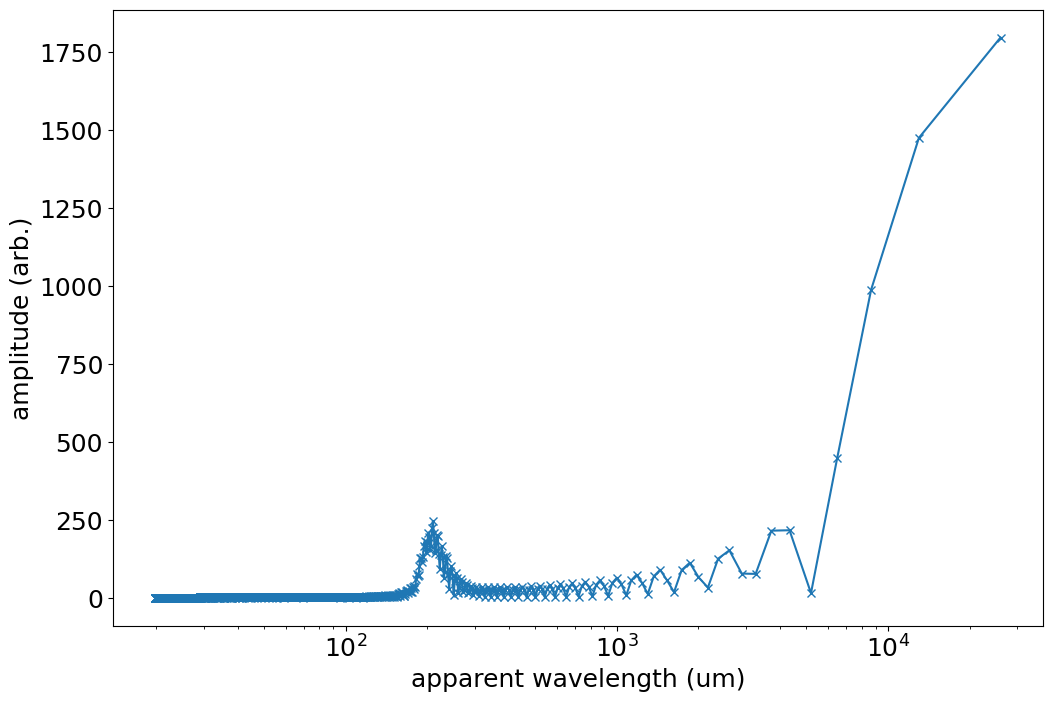

In [19]:
amplitude = np.zeros(num_of_freqs)
amplitude[0] = np.abs(FT[0])
amplitude, wavelengths, freqs = Coeffients2Amplitudes(FT, freqs)

plt.figure(figsize = (12,8))
plt.subplot(1, 1, 1)

plt.plot(wavelengths,
        amplitude,
        marker = "x")
plt.xlabel('apparent wavelength (um)')
plt.ylabel('amplitude (arb.)')
plt.xscale("log")
plt.show()

In [20]:
################COMPENSATE FOR ANGLE#################
if angle_calculation_method == "manual":
    theta = angle_between_beams/2 *np.pi/180
if angle_calculation_method == "wavelength":

    peaks, peak_properties = scisig.find_peaks(amplitude[1:], prominence = 0)
    best_peak = np.argmax(peak_properties["prominences"])
    max_index = peaks[best_peak] +1

    theta = np.arcsin(calibration_wavelength /2 /wavelengths[max_index])
    angle_between_beams = 2 *theta *180/np.pi #convert from radians to degrees
    print("angle between beams = {0:.3f}° or {1:.1f} arcminutes".format(angle_between_beams, 60*angle_between_beams))

corrected_wavelengths = wavelengths *2*np.sin(theta)
corrected_frequencys = recip(corrected_wavelengths)

In [21]:
###################CREATING AN EXPECTED SPECTRUM USING MANUFACURER DATA################## #I made a mess here. Pls clean up.

amplitude = amplitude /np.nanmax(amplitude[:-1]) #normalise

manta_data = import_normalised_csv("mantra_spectrum.csv", 0)
manta_data[:,0] = recip(manta_data[:,0]*1e-3) #convert nm to THz
manta_function = sciinter.interp1d(manta_data[:,0], manta_data[:,1], fill_value= np.nan, bounds_error= False)

purple_data = import_normalised_csv("PV320_spectrum.csv", 0)
purple_data[:,0] = recip(purple_data[:,0]*1e-3) #convert nm to THz
purple_function = sciinter.interp1d(purple_data[:,0], purple_data[:,1], fill_value= np.nan, bounds_error= False)

ir_data = import_normalised_csv("SLS201L_spectrum.csv", 1)
ir_data[:,0] = recip(ir_data[:,0]*1e-3) #convert nm to THz
ir_function = sciinter.interp1d(ir_data[:,0], ir_data[:,1], fill_value= np.nan, bounds_error= False) #Also try fill_value= np.nan

big_data = import_normalised_csv("SLS303_spectrum.csv", 1)
big_data[:,0] = recip(big_data[:,0]*1e-3) #convert nm to THz
big_function = sciinter.interp1d(big_data[:,0], big_data[:,1], fill_value= np.nan, bounds_error= False) #Also try fill_value= np.nan

def camera_function(x):
        return (manta_function(x)**(camera == "manta") *
                purple_function(x)**(camera == "purple"))


def manufacturers_function(x):
        return (ir_function(x)**(source == "ir") * #source_function if true, 1 if false. I'm kinda proud of this. I think it's a neat solution.
                big_function(x)**(source == "big") *
                manta_function(x)**(camera == "manta") )#*
                #purple_function(x)**(camera == "purple"))

percentagediff = (manufacturers_function(corrected_frequencys[:-1]) - amplitude[:-1]) /amplitude[:-1]
amplitude *= np.nanpercentile(percentagediff[percentagediff != -1], 2) +1 #re-scale to fit

normalised_amplitude = amplitude / camera_function(corrected_frequencys) #factor in the camera sensitivity

C:\Users\syf83691\AppData\Local\Temp\ipykernel_21056\1039869562.py:16: RuntimeWarning: divide by zero encountered in divide
  return C*1e-6 / x #converts um to THz or vice versa. be careful with units #1e4 / x #converts um to cm^-1 or vice versa. be careful with units


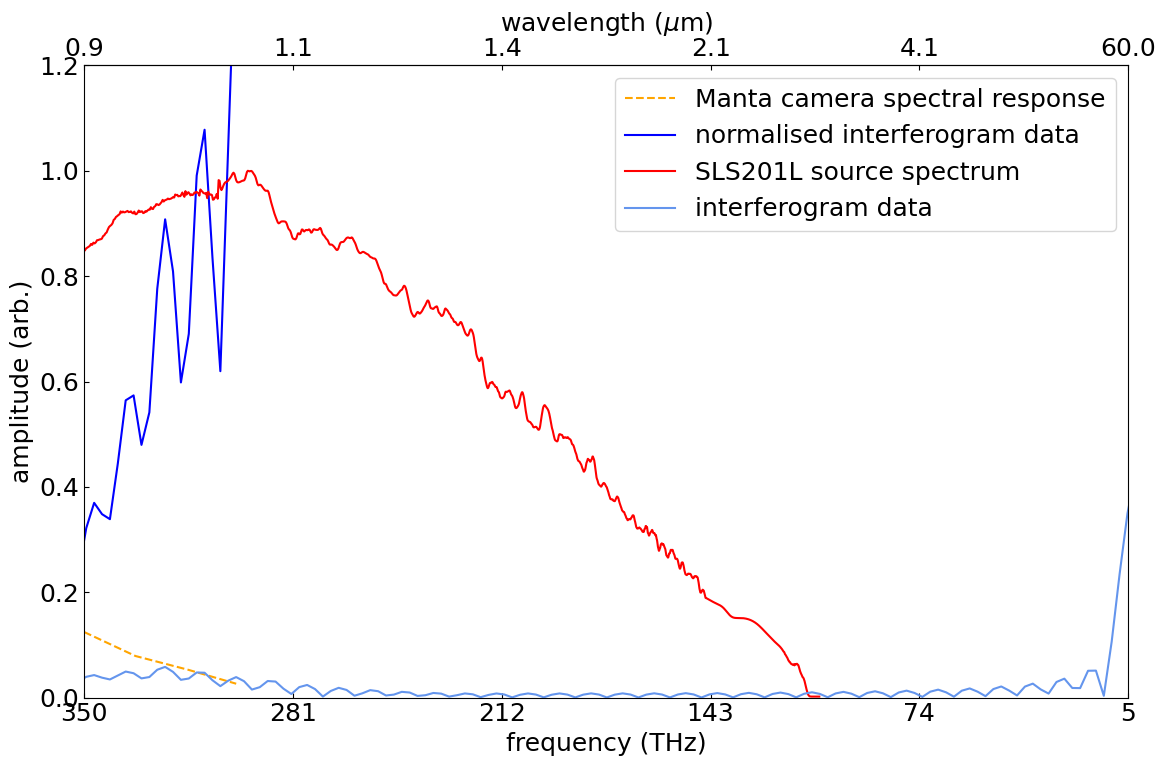

In [22]:
wavenumber_limits = [5,350] #THz

###Create graph
plt.figure(figsize = (12,8))
ax1 = plt.subplot(1, 1, 1)

###Import data to plot
if camera == "manta": 
        ax1.plot(manta_data[:,0],
                manta_data[:,1],
                label = "Manta camera spectral response",
                color = "orange",
                linestyle = "--")
        ax1.plot(corrected_frequencys,
                normalised_amplitude,
                label = "normalised interferogram data",
                color = "blue")
elif camera == "purple":
        ax1.plot(purple_data[:,0],
                purple_data[:,1],
                label = "PV320 camera spectral response",
                color = "violet",
                linestyle = "--")
        #ax1.plot(corrected_frequencys,
        #        normalised_amplitude,
        #        label = "normalised interferogram data",
        #        color = "blue")
if angle_calculation_method == "wavelength":
        try:
                plt.axvline(recip(calibration_wavelength), color = source)
        except ValueError:
                plt.axvline(recip(calibration_wavelength), color = "k")
if source == "ir":
        ax1.plot(ir_data[:,0],
                ir_data[:,1],
                label = "SLS201L source spectrum",
                color = "red")
elif source == "big":
        ax1.plot(big_data[:,0],
                big_data[:,1],
                label = "SLS303 source spectrum",
                color = "red")

ax1.plot(corrected_frequencys,
        amplitude,
        label = "interferogram data",
        color = "cornflowerblue")

###customise axis
secax = ax1.secondary_xaxis('top', functions=(recip, recip))

ax1.set_xlabel('frequency (THz)')
ax1.set_xticks(np.linspace(*wavenumber_limits,6))
ax1.tick_params(direction = "in")
secax.set_xlabel('wavelength ($\mu$m)')
secax.set_xticks(recip(np.linspace(*wavenumber_limits,6)))
secax.xaxis.set_major_formatter(FuncFormatter(format_ticks))
secax.tick_params(direction = "in")

plt.ylabel('amplitude (arb.)')
plt.ylim(0,1.2)
plt.xlim(*wavenumber_limits[::-1])

###show legend and graph
plt.legend()
plt.tight_layout()
plt.show()

C:\Users\syf83691\AppData\Local\Temp\ipykernel_21056\1039869562.py:16: RuntimeWarning: divide by zero encountered in divide
  return C*1e-6 / x #converts um to THz or vice versa. be careful with units #1e4 / x #converts um to cm^-1 or vice versa. be careful with units


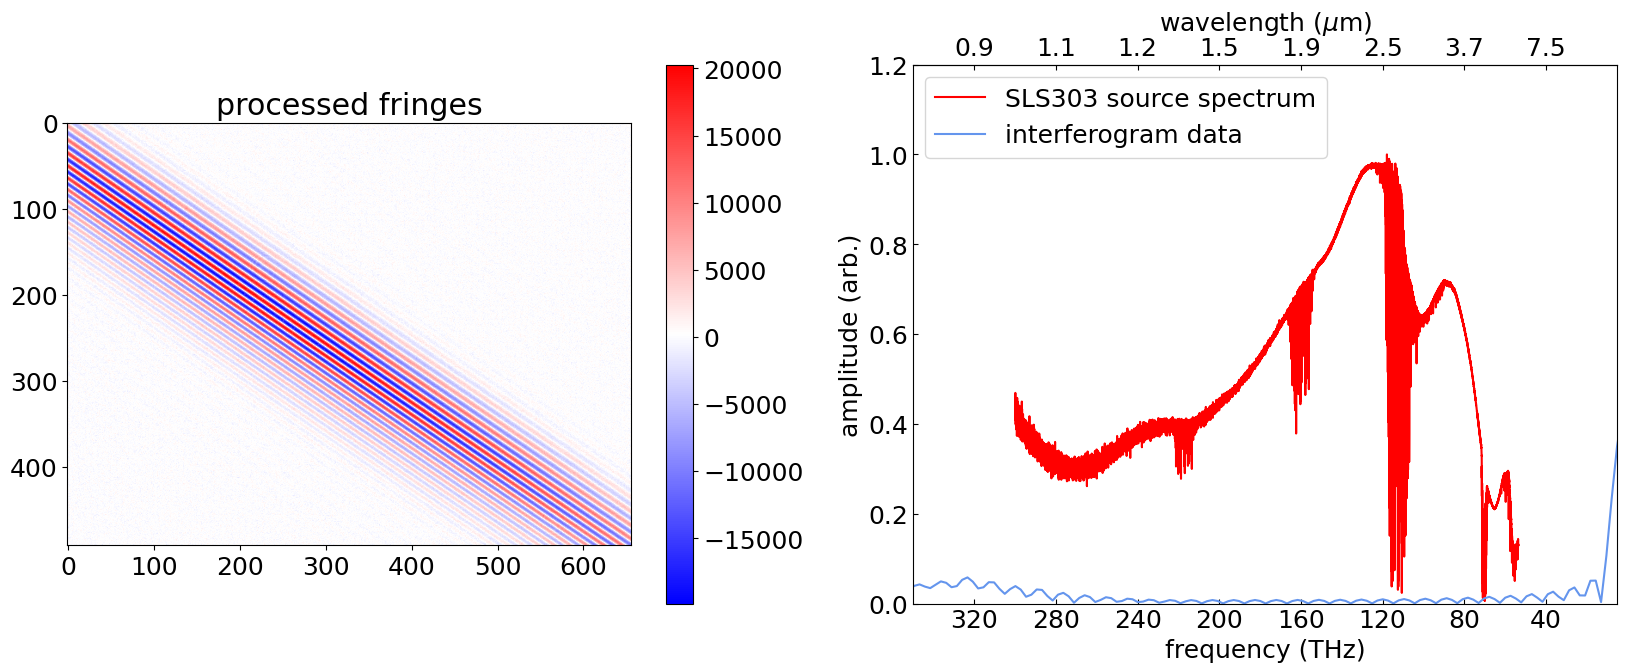

In [23]:
plt.figure(figsize = (20,7)) #This is the right aspect ratio for my slides.

ax = plt.subplot(1,2,1)
im=plt.imshow(reference_processed, cmap='bwr')
plt.colorbar(im)
plt.title("processed fringes")

ax1 = plt.subplot(1,2,2)

ax1.plot(big_data[:,0],
        big_data[:,1],
        label = "SLS303 source spectrum",
        color = "red")
ax1.plot(corrected_frequencys,
        amplitude,
        label = "interferogram data",
        color = "cornflowerblue")

###customise axis
secax = ax1.secondary_xaxis('top', functions=(recip, recip))

ax1.set_xlabel('frequency (THz)')
ax1.set_xticks([40,80,120,160,200,240,280,320])
ax1.tick_params(direction = "in")
secax.set_xlabel('wavelength ($\mu$m)')
secax.set_xticks(recip(np.array([40,80,120,160,200,240,280,320])))
secax.tick_params(direction = "in")
secax.xaxis.set_major_formatter(FuncFormatter(format_ticks))

plt.ylabel('amplitude (arb.)')
plt.ylim(0,1.2)
plt.xlim(*wavenumber_limits[::-1])

###show legend and graph
plt.legend()
plt.show()

plt.show()